In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pump-sensor-data/sensor.csv


In [2]:
import pandas_profiling as pp
from pandas_profiling import ProfileReport
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import tensorflow as tf
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, classification_report
from sklearn.preprocessing import LabelBinarizer
import random

pd.options.display.max_columns = None

## DATA LOADING, CLEANING AND EXPLORATORY DATA ANALYSIS

In [3]:
# I had checked the file first, I know that first row is the column headers and the first column is the index.
# Let's read it into a pandas dataframe
sensor_data = pd.read_csv(os.path.join(dirname, filename), index_col=0, header=0)

In [4]:
# Let's first do some data exploration and get some insights about data
# I, at first, used pandas profiling but over all the data set it took some much time and the output file was too big
# Therefore, I use the minimal calculations to get an insight. 
# But I will do manual EDA to show my reasoning. Therefore, I commented the python code below.
# Feel free to uncomment it at your interest

#profile = ProfileReport()
#profile = pp.ProfileReport(sensor_data, minimal=True)
#profile.to_file("output.minimal.html")

In [5]:
# Let's see first 10 rows
sensor_data.head(10)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.989580,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.989580,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,NaN,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.468750,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,NaN,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.468750,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,NaN,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.989580,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL
5,2018-04-01 00:05:00,2.453588,47.09201,53.1684,46.397568,637.6157,78.18568,13.41146,16.16753,15.89265,15.16204,39.29406,49.37051,32.23816,1.673484,418.9049,NaN,461.8948,461.9289,2.507935,663.4962,398.6428,872.4973,498.4064,974.6847,624.3462,739.2036,846.4617,429.6945,777.2820,700.7193,623.1481,734.3750,711.2128,438.6517,162.8758,333.7975,196.4579,90.84048,42.70833,31.77083,79.94791,30.989580,31.250000,42.70833,38.773150,63.65741,51.79398,38.773150,164.6412,66.55093,241.6088,201.6782,NORMAL
6,2018-04-01 00:06:00,2.455556,47.04861,53.1684,46.397568,633.3333,75.81614,13.43316,16.13136,15.65393,15.08247,38.29974,49.57146,32.00982,1.684984,420.3324,NaN,464.2402,467.5146,2.598702,667.4751,401.1847,882.7164,500.4944,981.2908,631.2756,740.9517,853.9647,458.3623,771.8188,722.5254,674.0740,707.8125,716.1951,433.5065,161.9678,330.3747,194.0652,89.23161,42.70833,32.29166,79.94791,31.250000,31.510420,43.22916,38.194440,61.92130,51.79398,39.062500,171.8750,67.70834,240.1

In [6]:
# Let's get basic info
sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220320 entries, 0 to 220319
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       220320 non-null  object 
 1   sensor_00       210112 non-null  float64
 2   sensor_01       219951 non-null  float64
 3   sensor_02       220301 non-null  float64
 4   sensor_03       220301 non-null  float64
 5   sensor_04       220301 non-null  float64
 6   sensor_05       220301 non-null  float64
 7   sensor_06       215522 non-null  float64
 8   sensor_07       214869 non-null  float64
 9   sensor_08       215213 non-null  float64
 10  sensor_09       215725 non-null  float64
 11  sensor_10       220301 non-null  float64
 12  sensor_11       220301 non-null  float64
 13  sensor_12       220301 non-null  float64
 14  sensor_13       220301 non-null  float64
 15  sensor_14       220299 non-null  float64
 16  sensor_15       0 non-null       float64
 17  sensor_16 

In [7]:
# Let's make some preprocessing.
# convert str to datetime, set it as the index and remove empty sensor column

sensor_data.timestamp = pd.to_datetime(sensor_data.timestamp)
sensor_data.drop(columns=['sensor_15'], inplace=True)

In [8]:
sensor_data.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,215725.000000,220301.000000,220301.000000,220301.000000,220301.000000,220299.000000,220289.000000,220274.000000,220274.000000,220304.000000,220304.000000,220304.000000,220279.000000,220304.000000,220304.000000,220284.000000,220300.000000,220304.000000,220304.000000,220248.000000,220059.000000,220304.00000,220252.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,14.799210,41.470339,41.918319,29.136975,7.078858,376.860041,416.472892,421.127517,2.303785,590.829775,360.805165,796.225942,459.792815,922.609264,556.235397,649.144799,786.411781,501.506589,851.690339,576.195305,614.596442,863.32310,804.283915,486.405980,234.971776,427.129817,593.033876,60.787360,49.655946,36.610444,68.844530,35.365126,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,2.091963,12.093519,13.056425,10.113935,6.901755,113.206382,126.072642,129.156175,0.765883,199.345820,101.974118,226.679317,154.528337,291.835280,182.297979,220.865166,246.663608,169.823173,313.074032,225.764091,195.726872,283.54476,260.602361,150.751836,88.376065,141.772519,289.385511,37.604883,10.540397,15.613723,21.371139,7.898665,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,0.000000,0.000000,0.000000,0.000000,0.000000,32.409550,0.000000,0.000000,0.000000,0.000000,0.000000,95.527660,0.000000,0.000000,0.000000,0.000000,43.154790,0.000000,4.319347,0.636574,0.000000,23.95833,0.240716,6.460602,54.882370,0.000000,2.260970,0.000000,24.479166,19.270830,23.437500,20.833330,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,15.053530,40.705260,38.856420,28.686810,1.538516,418.103250,459.453400,454.138825,2.447542,662.768975,398.021500,875.464400,478.962600,950.922400,601.151050,693.957800,790.489575,448.297950,782.682625,518.947225,627.777800,839.06240,760.607475,489.761075,172.486300,353.176625,288.547575,28.799220,45.572910,32.552080,57.812500,32.552080,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,15.082470,44.291340,45.363140,32.515830,2.929809,420.106200,462.856100,462.020250,2.533704,665.672400,399.367000,879.697600,531.855900,981.925000,625.873500,740.203500,861.869600,494.468450,967.279850,564.872500,668.981400,917.70830,878.850750,512.271750,226.356050,473.349350,709.668050,64.295485,49.479160,35.416660,66.406250,34.895832,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,15.118630,47.463760,49.656540,34.939730,12.859520,420.997100,464

In [9]:
# let's fill the missing data. 
# Since this is a time-series data, I forward-fill the missing data with the last measured value. 

sensor_data.fillna(method='ffill', inplace=True)

In [10]:
# Let's look at the data again. Now all the count values in the first row should be 
# equal to the number of sensor measurements.

sensor_data.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000
mean,2.281158,47.597254,50.867093,43.752337,590.664106,73.394872,13.209623,15.498316,14.872618,14.491819,41.469733,41.917808,29.136158,7.078588,376.852660,416.447232,421.070558,2.303471,590.829197,360.804938,796.225605,459.741072,922.607597,556.235014,649.087961,786.398042,501.504315,851.691020,576.053806,614.035146,863.323847,804.124214,486.407377,234.971366,427.126848,593.021870,60.788468,49.655294,36.610044,68.843870,35.364745,35.453143,43.879263,42.656415,43.094291,48.017908,44.340380,150.886798,57.119821,468.549868,258.266994
std,0.585413,3.302558,3.667314,2.418979,144.042134,17.301042,2.901954,3.152707,2.956980,2.956122,12.094658,13.057506,10.114627,6.901627,113.215750,126.106597,129.239423,0.766304,199.347434,101.974905,226.680266,154.592696,291.835265,182.299572,220.932883,246.679222,169.817523,313.072017,225.920676,196.337797,283.542056,260.838475,150.752352,88.377216,141.772835,289.392147,37.603934,10.540293,15.612883,21.370838,7.898342,10.258958,11.043951,11.575867,12.836955,15.640575,10.441987,82.243950,19.143759,393.067670,228.890462
min,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,0.000000,0.000000,0.000000,0.000000,0.000000,32.409550,0.000000,0.000000,0.000000,0.000000,0.000000,95.527660,0.000000,0.000000,0.000000,0.000000,43.154790,0.000000,4.319347,0.636574,0.000000,23.958330,0.240716,6.460602,54.882370,0.000000,2.260970,0.000000,24.479166,19.270830,23.437500,20.833330,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,2.419155,46.310760,50.390620,42.838539,626.620400,69.976258,13.317420,15.856480,15.147570,15.010130,40.704892,38.856392,28.684967,1.538513,418.103075,459.450775,454.133875,2.447486,662.769275,398.021675,875.464800,478.956850,950.922700,601.151175,693.938675,790.486550,448.298375,782.684200,518.878350,627.777800,839.062400,760.465050,489.762750,172.486375,353.168325,288.523750,28.803398,45.572910,32.552080,57.812500,32.552080,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,182.581000,180.555600
50%,2.455556,48.133680,51.649300,44.227428,632.638916,75.576430,13.628470,16.167530,15.451390,15.082470,44.291375,45.363450,32.515755,2.930246,420.106100,462.856100,462.019150,2.533696,665.672250,399.367000,879.697800,531.854650,981.924850,625.873550,740.201350,861.856650,494.465650,967.273900,564.846700,668.981400,917.708300,878.818750,512.274200,226.354250,473.347850,709.658150,64.296480,49.479160,35.416660,66.406250,34.895832,35.156250,42.968750,40.509260,40.219910,44.849540,42.245370,138.020800,52.662040,222.511600,199.942100
75%,2.499826,49.479160,52.777770,45.312500,637.615723,80.911770,14.539930,16.427950,15.697340,15.118630,47.464360,49.656238,34.939632,12.859483,420.997

In [11]:
# Our data is highly imbalanced!

sensor_data.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

In [12]:
# let us take a dive and see a breakdown of the pump

broken_indeces = sensor_data[sensor_data.machine_status.isin(['BROKEN'])].index
broken_indeces

Int64Index([17155, 24510, 69318, 77790, 128040, 141131, 166440], dtype='int64')

In [13]:
# You can set ind and num_points to see the breakdown points in time, just to get 
# a rough idea of how long the recovering time takes. 

ind = 1 # ind value should be in between 0-6
num_points = 2500 # number of point before and after the break down
start_ind = broken_indeces[ind] - num_points
end_ind = broken_indeces[ind] + num_points
x=sensor_data.iloc[start_ind:end_ind]['timestamp']
y=sensor_data.iloc[start_ind:end_ind]['machine_status']
px.scatter(x=x, y=y)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

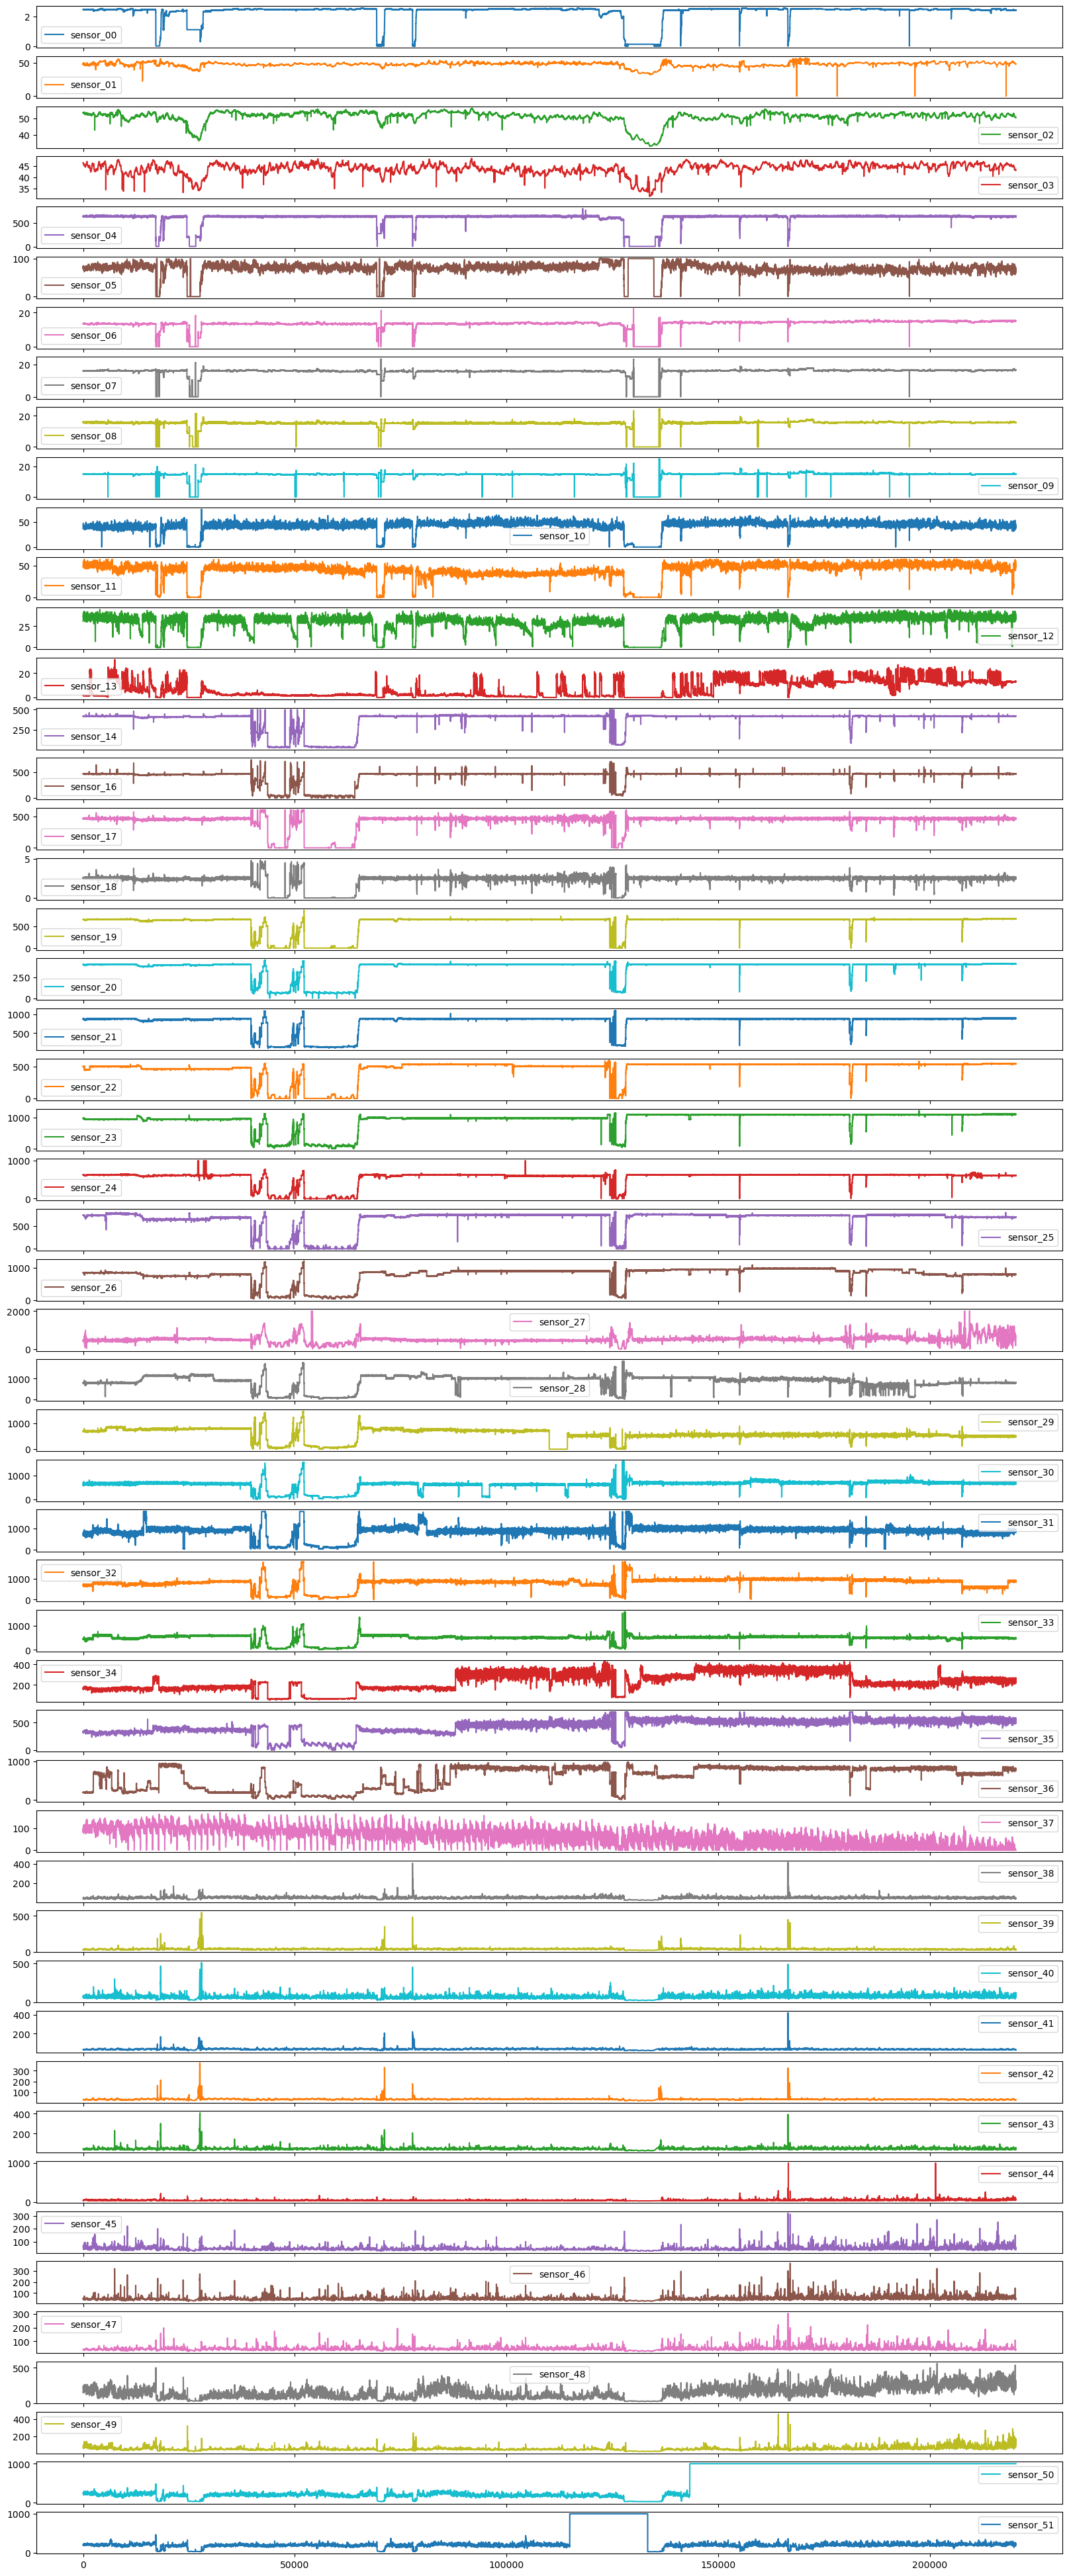

In [14]:
# It looks like some of the sensors show the same behavior, even though they different scales. 
# We might group the sensor in terms of their behaviour.

sensor_data.drop(columns=['timestamp']).plot(subplots=True, sharex = True, figsize = (20,50))

array([<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
      

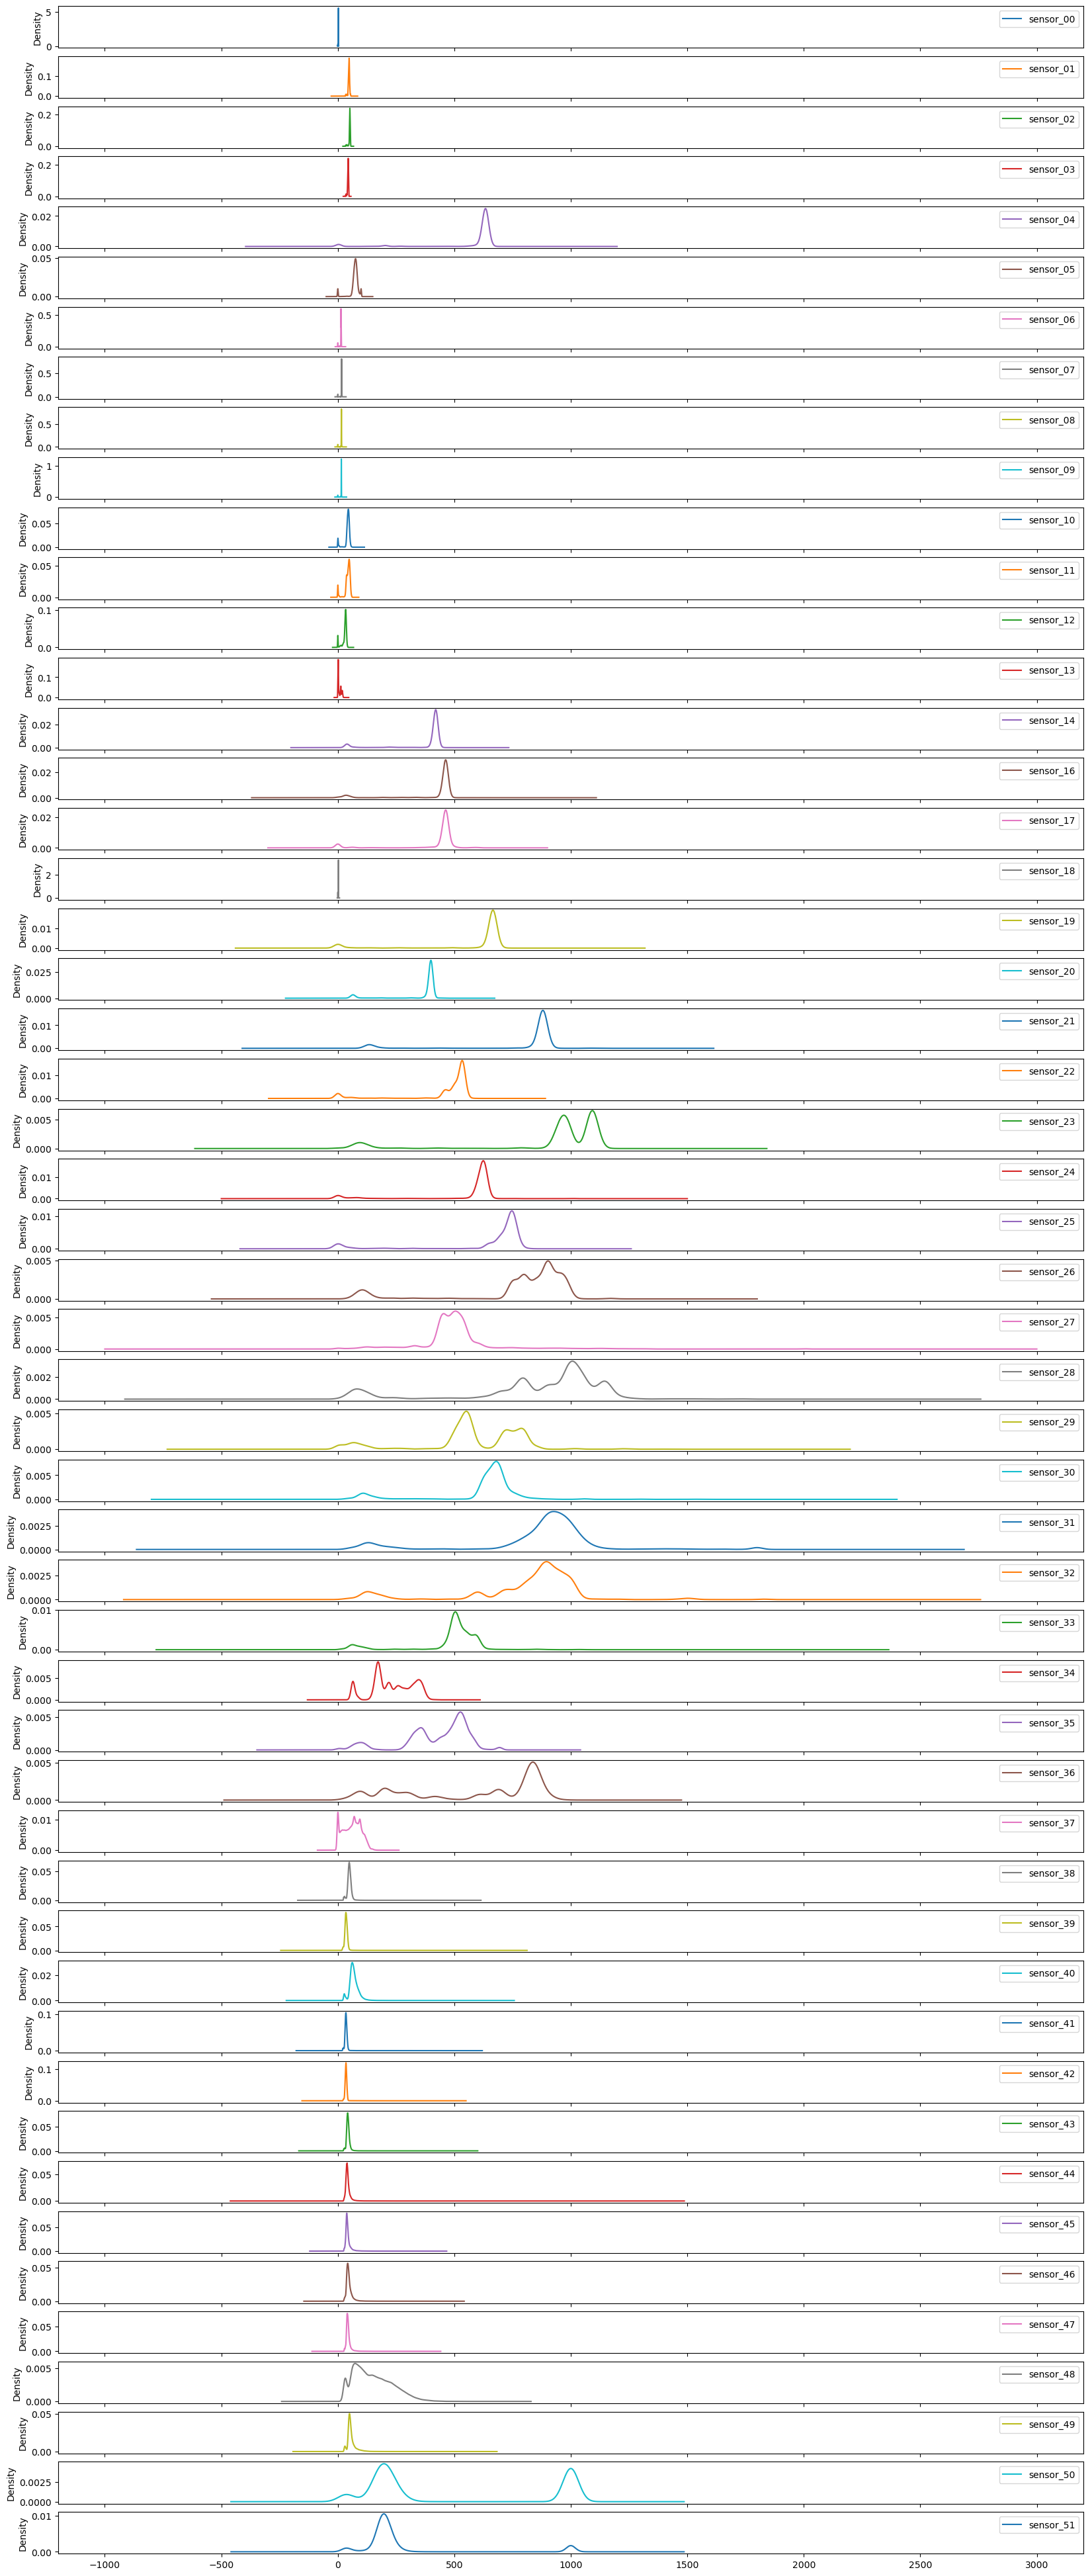

In [15]:
# As we suspected above, some sensor sets show the similar shapes.

sensor_data.drop(columns=['timestamp','machine_status']).plot(kind='kde',subplots=True, sharex = True, figsize = (20,50))

## FEATURE SELECTION

In [16]:
# The correlation plot below justify my belief that there is a strong corrleation among some sensors!
# It looks like there are at least 3 (or more) groups of sensors which behave the same.

corr = sensor_data.drop(columns=['timestamp','machine_status']).corr().values
px.imshow(corr)

In [17]:
# We should do some feature selection. I consider using an unsupervised method as a preprocessing step before
# deciding which ML method to use. 
# We can also use the PCA (principal component analysis) as a dimension reduction technique to both reduce
# dimensions and create uncorrelated features
# Also there are also supervised feature selection wrapper in sklearn, too


# I would consider using a clustering algorithm to get the correlated feature set.
# Though k-means or spectral clustering could be used, I would consider the hierarchical clustering

from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd

distances = 1 - corr # convert correlations to distance since a distance can not be negative

threshold = 0.20

distance_array = ssd.squareform(distances)
hier = hierarchy.linkage(distance_array, method="ward")
assignments=hierarchy.cut_tree(hier,height=threshold)

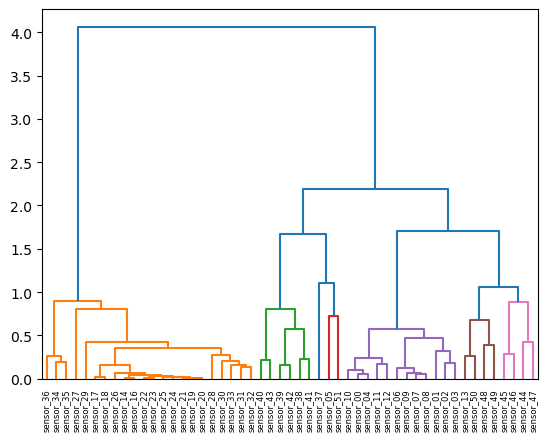

In [18]:
# Let's see how the hierarchical clustering wrt the correlations as distances

dend = hierarchy.dendrogram(hier, truncate_mode="level", color_threshold=1.0, 
                            labels=sensor_data.drop(columns=['timestamp','machine_status']).columns)

In [19]:
# Let's set the threshold to create the clusters

cluster_labels = hierarchy.fcluster(hier, threshold, criterion="distance")
unique, unique_counts = np.unique(cluster_labels, return_counts=True)

In [20]:
cluster_labels

array([17, 21, 20, 20, 17, 14, 19, 19, 19, 19, 17, 18, 18, 22,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  8,  6,  7,  5,  4,  4,  4,  1,
        1,  2, 16, 12, 11,  9, 13, 11, 10, 28, 26, 27, 29, 24, 25, 23, 15],
      dtype=int32)

In [21]:
unique_counts

array([ 2,  1, 12,  3,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  3,
        2,  4,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [22]:
# Let's visualize the clusters

means = (len(np.unique(cluster_labels)) + 1) * [0.0]
counts = (len(np.unique(cluster_labels)) + 1) * [0]
new_label = np.zeros(corr.shape)
for ind1, label1 in enumerate(cluster_labels):
    for ind2, label2 in enumerate(cluster_labels):
        if label1 == label2:
            new_label[ind1, ind2] = label1
            if ind1 != ind2:
                means[label1] += corr[ind1, ind2]
                counts[label1] += 1

px.imshow(new_label) 

In [23]:
# As the  hierarchical clustering shows there are 4 major clusters, but also small clusters

column_list = list(zip(sensor_data.drop(columns=['timestamp','machine_status']).columns, assignments))

### Extract the columns closest to cluster centroids
counter = 0
selected_columns = [] # Will contain the selected features (sensors)
while counter < max(assignments) + 1:

    # Create mask from the list of assignments for extracting submatrix of the cluster
    mask = np.array([1 if i==counter else 0 for i in assignments],dtype=bool)

    # Take the index of the column with the smallest sum of distances from the submatrix
    idx = np.argmin(sum(1 - corr[:,mask][mask,:]))

    # Extract names of cluster elements from nameList
    sublist = [col_name for (col_name, cluster) in column_list if cluster==counter]

    # Element closest to centroid
    selected_columns.append(sublist[idx])
    
    # Increment counter
    counter += 1

In [24]:
# Let's extract the selected features (sensors) from data

X = sensor_data.drop(columns=['timestamp', 'machine_status'])[selected_columns].copy()
y = sensor_data['machine_status'].copy().to_frame()

## ENSEMBLE AND CROSS-VALIDATION 

In [25]:
# This problem can be modelled in multiple ways
# 1 - We can model as an outlier detection problem (NORMAL vs NOT NORMAL)
# 2 - We can model as a multi-class classification (even though imbalanced data)
# 3 - We can model as a regression problem


# I will use the regression as a classifier! Therefore, I will use the third method!
# Let's convert the machine status values into the numeric values for regression

y['machine_status'].replace(to_replace={'NORMAL': 1.0, 'RECOVERING': 0.5, 'BROKEN': 0.0}, inplace=True)

In [26]:
# This is a prediction for the future breakdown. Therefore, we need to predict 'k' steps (mins) ahead. 

# I propose an ensemble of different methods. I will create three different regressors:
# 1 - A LSTM (time-series) based DL regressor
# 2 - A CNN (the time window is used like an image) based regressor
# 3 - A DNN (the time window is flattened) regressor

# Later I will convert regression value to class labels such that 
# [0.0, 1/3] -> BROKEN
# (1/3, 2/3) -> RECOVERING
# [2/3, 1.0] -> NORMAL

In [27]:
# The function below shifts (lags) the series with the given value
def convert_series_to_lagged_series(data, shift_num=1, drop_nan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, col_names = list(), list()
    for s in range(0, shift_num):
        cols.append(dff.shift(-s))
        if s==0:
            col_names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            col_names += [('var%d(t+%d)' % (j+1,s)) for j in range(n_vars)]
    aggragetor = pd.concat(cols, axis=1)
    aggragetor.columns = col_names
    if drop_nan:
        aggragetor.dropna(inplace=True)
    return aggragetor

In [28]:
# The dataset is very very highly imbalanced!

# We could have used a sampling method (under/oversampling) for a sampling library (E.g. imblearn) if we designed our problem as a classification
# instance. I come up with a customized 'selective' sampling. I will partition the time series data into 7 subsets such that each time interval contains
# 1 'BROKEN' data points and 2500 data points before and after the breakdown. While the before the breakdowm data points will most likely be 'NORMAL',
# while the points after might either 'NORMAL' or 'RECOVERING'.

# In this manner, I will apply manual 7-fold cv to evaluate the performance of the system. I create a customized cv loop for it.

In [29]:
# This is customized class label assigner. Since we used a regressor, here we convert its output to class labels

def assign_classes(y_pred_):
    y_pred = y_pred_.copy()
    y_pred[y_pred<1/3] = 0 # BROKEN
    y_pred[y_pred>2/3] = 1 # NORMAL
    y_pred[(1/3 <= y_pred) & (y_pred  <= 2/3)] = 0.5 # RECOVERING
    return y_pred

Fold =  1
Epoch 1/100
12/12 [==============================] - 5s 50ms/step - loss: 0.0491
Epoch 2/100
12/12 [==============================] - 1s 53ms/step - loss: 0.0205
Epoch 3/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0143
Epoch 4/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0091
Epoch 5/100
12/12 [==============================] - 1s 58ms/step - loss: 0.0065
Epoch 6/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0051
Epoch 7/100
12/12 [==============================] - 1s 51ms/step - loss: 0.0043
Epoch 8/100
12/12 [==============================] - 1s 53ms/step - loss: 0.0037
Epoch 9/100
12/12 [==============================] - 1s 51ms/step - loss: 0.0032
Epoch 10/100
12/12 [==============================] - 1s 51ms/step - loss: 0.0028
Epoch 11/100
12/12 [==============================] - 1s 51ms/step - loss: 0.0025
Epoch 12/100
12/12 [==============================] - 1s 54ms/step - loss: 0.0023
Epoch 13/100
12

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



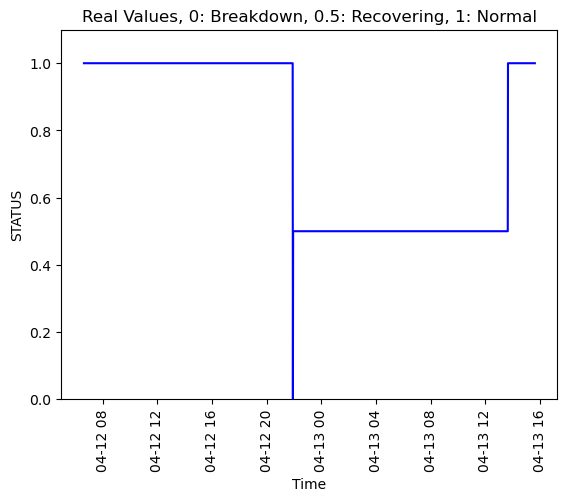

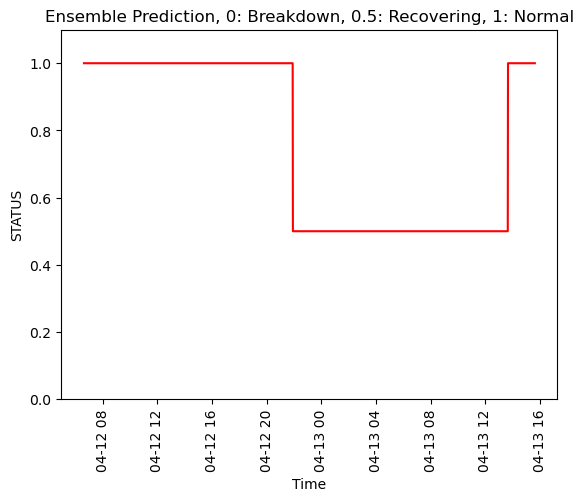

End of fold
Fold =  2
Epoch 1/100
12/12 [==============================] - 5s 52ms/step - loss: 0.0491
Epoch 2/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0235
Epoch 3/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0150
Epoch 4/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0094
Epoch 5/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0056
Epoch 6/100
12/12 [==============================] - 1s 53ms/step - loss: 0.0031
Epoch 7/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0021
Epoch 8/100
12/12 [==============================] - 1s 51ms/step - loss: 0.0018
Epoch 9/100
12/12 [==============================] - 1s 51ms/step - loss: 0.0016
Epoch 10/100
12/12 [==============================] - 1s 55ms/step - loss: 0.0015
Epoch 11/100
12/12 [==============================] - 1s 54ms/step - loss: 0.0015
Epoch 12/100
12/12 [==============================] - 1s 55ms/step - loss: 0.0014
Epo

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



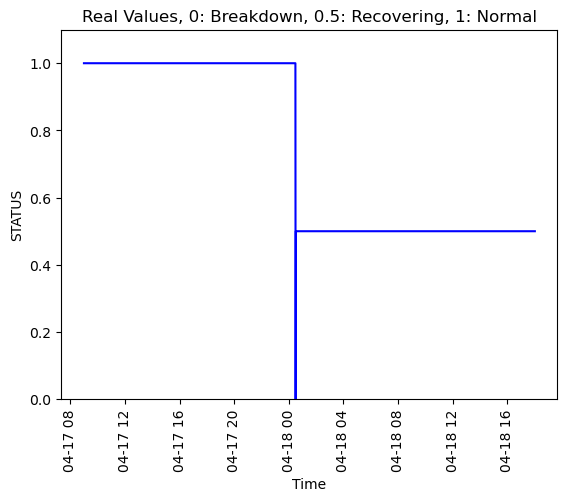

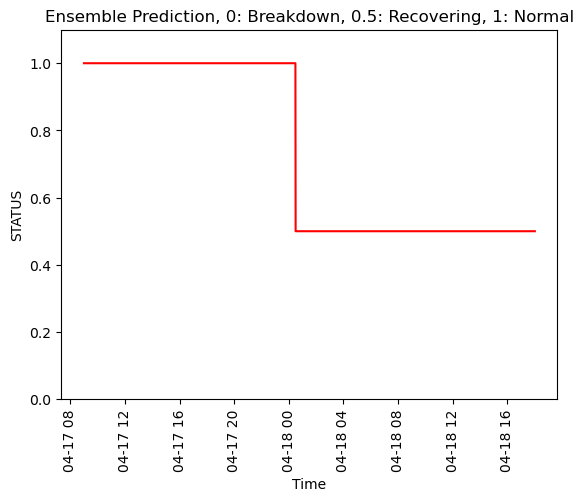

End of fold
Fold =  3
Epoch 1/100
12/12 [==============================] - 5s 51ms/step - loss: 0.0542
Epoch 2/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0311
Epoch 3/100
12/12 [==============================] - 1s 51ms/step - loss: 0.0183
Epoch 4/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0127
Epoch 5/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0083
Epoch 6/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0056
Epoch 7/100
12/12 [==============================] - 1s 51ms/step - loss: 0.0042
Epoch 8/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0035
Epoch 9/100
12/12 [==============================] - 1s 53ms/step - loss: 0.0030
Epoch 10/100
12/12 [==============================] - 1s 55ms/step - loss: 0.0028
Epoch 11/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0026
Epoch 12/100
12/12 [==============================] - 1s 55ms/step - loss: 0.0024
Epo

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



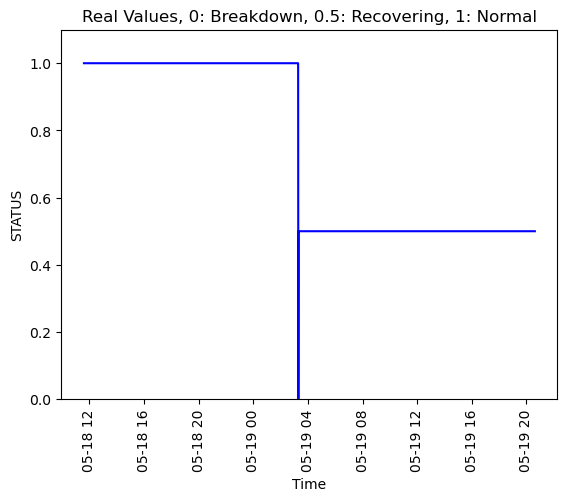

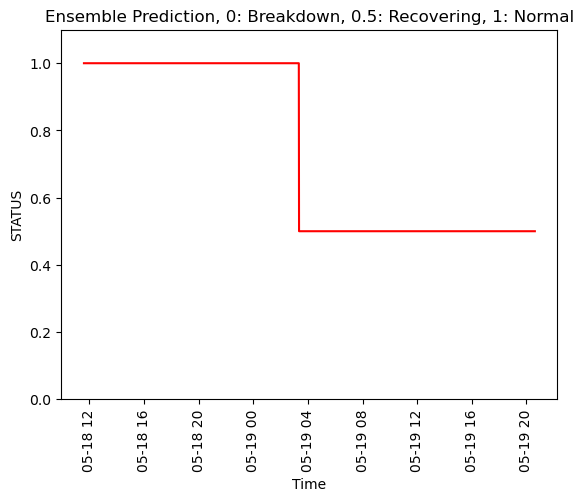

End of fold
Fold =  4
Epoch 1/100
12/12 [==============================] - 5s 53ms/step - loss: 0.0848
Epoch 2/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0714
Epoch 3/100
12/12 [==============================] - 1s 50ms/step - loss: 0.0388
Epoch 4/100
12/12 [==============================] - 1s 51ms/step - loss: 0.0213
Epoch 5/100
12/12 [==============================] - 1s 54ms/step - loss: 0.0192
Epoch 6/100
12/12 [==============================] - 1s 50ms/step - loss: 0.0150
Epoch 7/100
12/12 [==============================] - 1s 51ms/step - loss: 0.0115
Epoch 8/100
12/12 [==============================] - 1s 50ms/step - loss: 0.0076
Epoch 9/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0045
Epoch 10/100
12/12 [==============================] - 1s 53ms/step - loss: 0.0028
Epoch 11/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0018
Epoch 12/100
12/12 [==============================] - 1s 50ms/step - loss: 0.0013
Epo

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



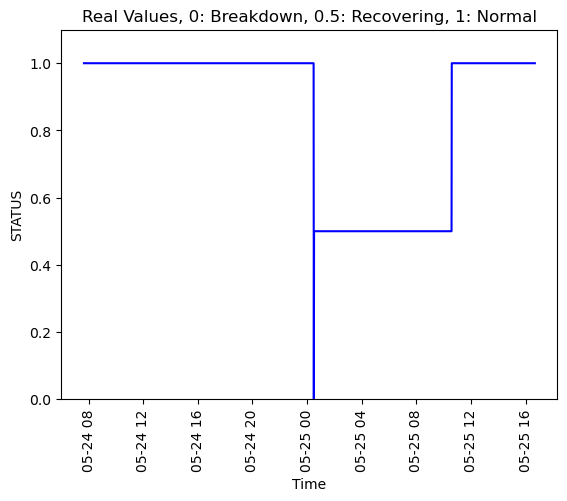

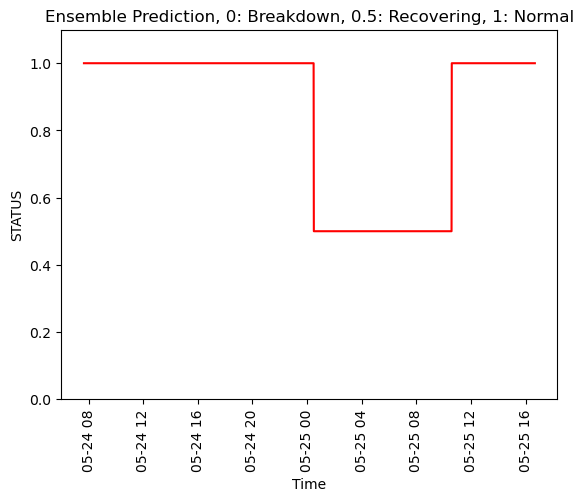

End of fold
Fold =  5
Epoch 1/100
12/12 [==============================] - 5s 50ms/step - loss: 0.0627
Epoch 2/100
12/12 [==============================] - 1s 50ms/step - loss: 0.0423
Epoch 3/100
12/12 [==============================] - 1s 50ms/step - loss: 0.0204
Epoch 4/100
12/12 [==============================] - 1s 50ms/step - loss: 0.0103
Epoch 5/100
12/12 [==============================] - 1s 58ms/step - loss: 0.0060
Epoch 6/100
12/12 [==============================] - 1s 60ms/step - loss: 0.0044
Epoch 7/100
12/12 [==============================] - 1s 55ms/step - loss: 0.0037
Epoch 8/100
12/12 [==============================] - 1s 50ms/step - loss: 0.0032
Epoch 9/100
12/12 [==============================] - 1s 53ms/step - loss: 0.0029
Epoch 10/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0027
Epoch 11/100
12/12 [==============================] - 1s 51ms/step - loss: 0.0026
Epoch 12/100
12/12 [==============================] - 1s 50ms/step - loss: 0.0024
Epo

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



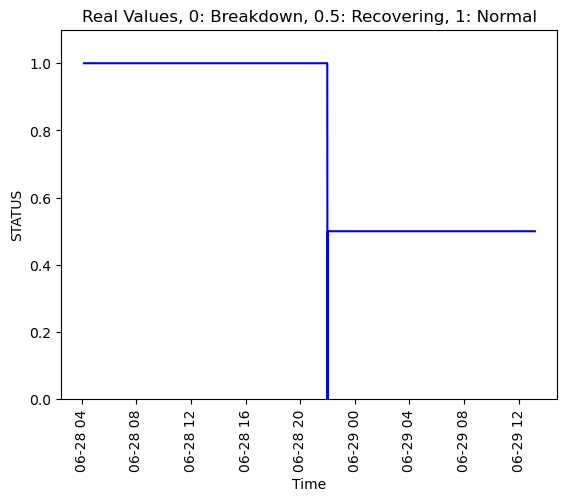

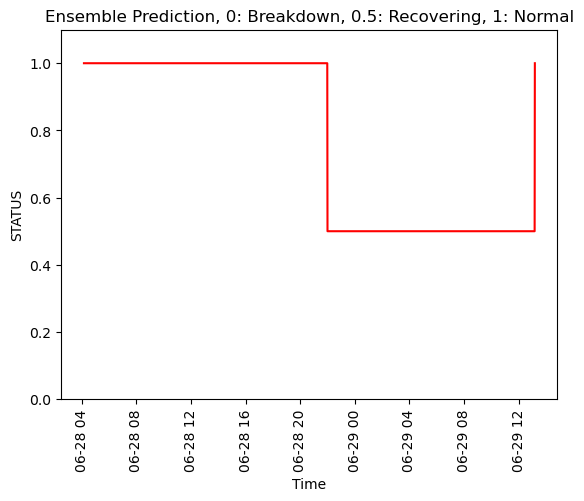

End of fold
Fold =  6
Epoch 1/100
12/12 [==============================] - 5s 52ms/step - loss: 0.1165
Epoch 2/100
12/12 [==============================] - 1s 51ms/step - loss: 0.0798
Epoch 3/100
12/12 [==============================] - 1s 51ms/step - loss: 0.0186
Epoch 4/100
12/12 [==============================] - 1s 53ms/step - loss: 0.0041
Epoch 5/100
12/12 [==============================] - 1s 51ms/step - loss: 0.0032
Epoch 6/100
12/12 [==============================] - 1s 50ms/step - loss: 0.0031
Epoch 7/100
12/12 [==============================] - 1s 49ms/step - loss: 0.0030
Epoch 8/100
12/12 [==============================] - 1s 50ms/step - loss: 0.0030
Epoch 9/100
12/12 [==============================] - 1s 49ms/step - loss: 0.0030
Epoch 10/100
12/12 [==============================] - 1s 49ms/step - loss: 0.0029
Epoch 11/100
12/12 [==============================] - 1s 50ms/step - loss: 0.0029
Epoch 12/100
12/12 [==============================] - 1s 53ms/step - loss: 0.0029
Epo

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



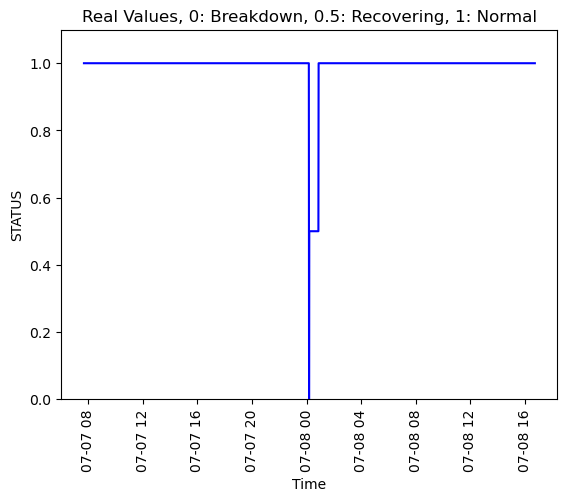

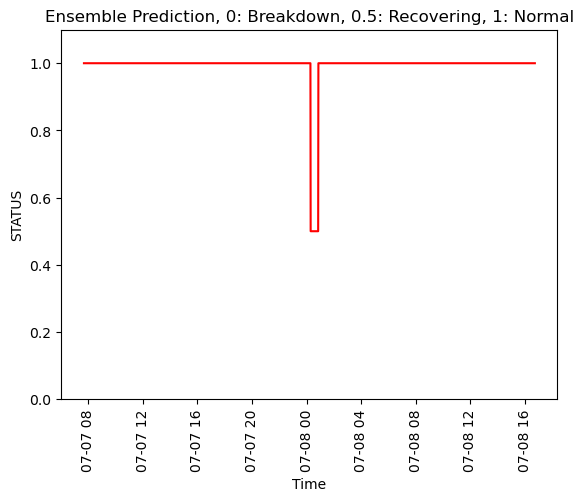

End of fold
Fold =  7
Epoch 1/100
12/12 [==============================] - 5s 51ms/step - loss: 0.0957
Epoch 2/100
12/12 [==============================] - 1s 51ms/step - loss: 0.0263
Epoch 3/100
12/12 [==============================] - 1s 51ms/step - loss: 0.0054
Epoch 4/100
12/12 [==============================] - 1s 50ms/step - loss: 0.0050
Epoch 5/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0050
Epoch 6/100
12/12 [==============================] - 1s 53ms/step - loss: 0.0049
Epoch 7/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0049
Epoch 8/100
12/12 [==============================] - 1s 51ms/step - loss: 0.0049
Epoch 9/100
12/12 [==============================] - 1s 54ms/step - loss: 0.0049
Epoch 10/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0049
Epoch 11/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0050
Epoch 12/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0049
Epo

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



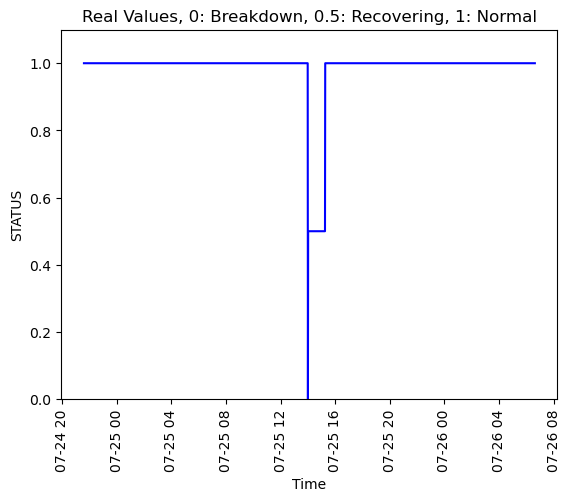

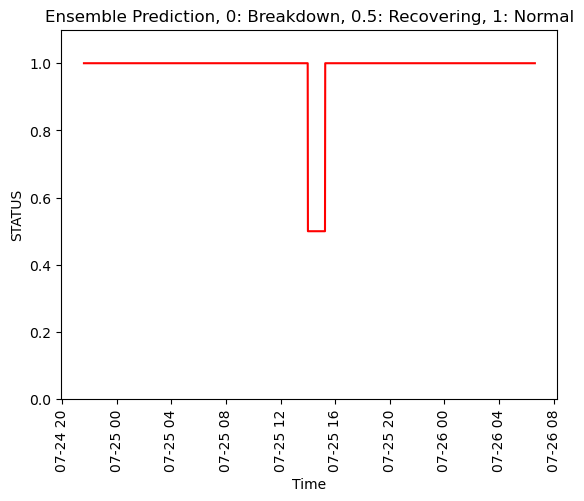

End of fold


In [37]:
random.seed(42)
tf.random.set_seed(42)

lag = 10 # This is past lag. If we want to predict the breakdown in the next 10 seconds, then we need to set this value 10
num_points = 1000 # The number of points around the brokendown point
window_size = 10 # This is the window size (number of consecutive time points) that needs to be stored
total_shift = window_size + lag # Used for shifting data later
broken_indices_shift_range = 100 # we even further shift the interval

average_machine_behaviours = []
average_sensor_behaviours = []
scaled_average_sensor_behaviours = []

fold_counter = 0
for ind in broken_indeces: # customized cv
    fold_counter += 1
    print("Fold = ", fold_counter)
    sampled_train_indices = []
    sampled_test_indices = []
    lag_window_test_indices = []
    broken_shift = random.randrange(-broken_indices_shift_range, broken_indices_shift_range + 1)
    for ind_int in broken_indeces:
        if ind_int != ind:
            sampled_train_indices.extend(np.arange(broken_shift + ind - num_points, broken_shift + ind + num_points + 1, dtype=int))
        else:
            sampled_test_indices.extend(np.arange(broken_shift + ind - num_points, broken_shift + ind + num_points + 1, dtype=int))
            lag_window_test_indices.extend(np.arange(ind - lag - window_size, ind + lag + 1, dtype=int))

    # the sampled training and its test sets
    x_train = X.iloc[sampled_train_indices,:].copy()
    y_train = y.iloc[sampled_train_indices,:].copy()

    x_test = X.iloc[sampled_test_indices,:].copy()
    y_test = y.iloc[sampled_test_indices,:].copy()

    x_test_lag_window = X.iloc[lag_window_test_indices,:].copy()
    y_test_lag_window = y.iloc[lag_window_test_indices,:].copy()

    # We are using min-max scaler to translate the features into the same scale of [0,1]
    scaler = MinMaxScaler()

    # Train the scaler
    scaler.fit(x_train)

    # Note that to compare and later merge the classifiers, we have to be sure that we are
    # using the same data points (consider windows and time lags)


    ####### LSTM MODEL ###########
    # scale the shifted input
    scaled_x_train = pd.DataFrame(scaler.transform(x_train.iloc[window_size-1:-lag,:]))
    scaled_x_test = pd.DataFrame(scaler.transform(x_test.iloc[window_size-1:-lag,:]))
    # shift the output
    y_train = y_train.iloc[total_shift-1:].copy()
    y_test = y_test.iloc[total_shift-1:].copy()

    # reformat the input for lstm
    lstm_x_train = scaled_x_train.values.reshape((scaled_x_train.shape[0], 1, scaled_x_train.shape[1]))
    lstm_x_test = scaled_x_test.values.reshape((scaled_x_test.shape[0], 1, scaled_x_test.shape[1]))

    # define lstm model
    lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(250, input_shape=(lstm_x_train.shape[1:]), return_sequences=True),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(100),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')])
    lstm_model.compile(loss='huber', optimizer='adam')

    # run the model and capture the results
    import seaborn as sns
    history_lstm = lstm_model.fit(lstm_x_train, y_train, epochs=100, batch_size=1024, shuffle=False)
    y_predict_lstm = lstm_model.predict(lstm_x_test)
    y_hat_lstm = assign_classes(y_predict_lstm)
    print("LSTM")
    lstm_conf = confusion_matrix(2*y_hat_lstm, 2*y_test.values)
    print(lstm_conf)
    #print(classification_report(2*y_hat_lstm, 2*y_test.values, target_names=['BROKEN', 'RECOVERING', 'NORMAL']))


    ####### CNN MODEL ###########
    # normalize the input
    scaled_x_train = pd.DataFrame(scaler.transform(x_train))
    scaled_x_test = pd.DataFrame(scaler.transform(x_test))

    # create the lagged time windows
    reframed_x_train = convert_series_to_lagged_series(scaled_x_train, total_shift)
    r = list(range((total_shift - lag) * scaled_x_train.shape[1], (total_shift) * scaled_x_train.shape[1]))
    reframed_x_train.drop(reframed_x_train.columns[r], axis=1, inplace=True)

    reframed_x_test = convert_series_to_lagged_series(scaled_x_test, total_shift)
    r = list(range((total_shift - lag) * scaled_x_test.shape[1], (total_shift) * scaled_x_test.shape[1]))
    reframed_x_test.drop(reframed_x_test.columns[r], axis=1, inplace=True)

    # reformat the input for CNN
    cnn_x_train = reframed_x_train.values.reshape((reframed_x_train.shape[0], 1, window_size, int(reframed_x_train.shape[-1]/window_size)))
    cnn_x_test = reframed_x_test.values.reshape((reframed_x_test.shape[0], 1, window_size, int(reframed_x_test.shape[-1]/window_size)))

    # define cnn model
    cnn_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters = 16 , kernel_size = 3 , padding='causal', activation='relu', input_shape = cnn_x_train.shape[1:]),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv1D(filters = 8 , kernel_size = 3, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    cnn_model.compile(loss=tf.keras.losses.Huber(),
             optimizer = tf.keras.optimizers.Adam(),
             metrics = ['mae'])

    # run the model and capture the results
    history_cnn = cnn_model.fit(cnn_x_train, y_train, epochs = 100, shuffle=True, batch_size=1024)
    y_predict_cnn = cnn_model.predict(cnn_x_test)
    y_hat_cnn = assign_classes(y_predict_cnn)
    print("CNN")
    cnn_conf = confusion_matrix(2*y_hat_cnn, 2*y_test.values)
    print(cnn_conf)
    # print(classification_report(2*y_hat_cnn, 2*y_test.values, target_names=['BROKEN', 'RECOVERING', 'NORMAL']))


    ####### DNN MODEL ###########
    # define Dnn model
    dnn_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(30, activation='relu', input_shape = reframed_x_train.shape[1:]),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(35, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    dnn_model.compile(loss=tf.keras.losses.Huber() ,
                      optimizer = tf.keras.optimizers.Adam(),
                      metrics = ['mae'])

    history_dnn = dnn_model.fit(reframed_x_train, y_train, epochs = 100, shuffle=True, batch_size=1024)
    y_predict_dnn = dnn_model.predict(reframed_x_test)
    y_hat_dnn = assign_classes(y_predict_dnn)
    print("DNN")
    dnn_conf = confusion_matrix(2*y_hat_dnn, 2*y_test.values)
    print(dnn_conf)
    # print(classification_report(2*y_hat_dnn, 2*y_test.values, target_names=['BROKEN', 'RECOVERING', 'NORMAL']))

    # Let's create a custom majority voter
    y_sk_labeled_dnn = LabelBinarizer().fit(range(3)).transform(2*y_hat_dnn)
    y_sk_labeled_cnn = LabelBinarizer().fit(range(3)).transform(2*y_hat_cnn)
    y_sk_labeled_lstm = LabelBinarizer().fit(range(3)).transform(2*y_hat_lstm)

    y_hat_sk_ensemble = y_sk_labeled_dnn + y_sk_labeled_cnn + y_sk_labeled_lstm
    y_predict_sk_ensemble  = np.argmax(y_hat_sk_ensemble, axis=1).reshape(len(y_sk_labeled_lstm), 1)
    print("Ensemble")
    ensemble_conf = confusion_matrix(y_predict_sk_ensemble, 2*y_test.values)
    print(ensemble_conf)
    ensemble_precision, ensemble_recall, ensemble_fbeta_score,_ = precision_recall_fscore_support(y_predict_sk_ensemble, 2*y_test.values)
    ensemble_accuracy = accuracy_score(y_predict_sk_ensemble, 2*y_test.values)
    print(f'Ensemble Accuracy: {ensemble_accuracy}')
    print(f'Ensemble (class-wise) Precision: {ensemble_precision}')
    print(f'Ensemble (class-wise) Recall: {ensemble_recall}')
    print(f'Ensemble (class-wise) F-Score: {ensemble_fbeta_score}')

    plt.figure()
    plt.plot(sensor_data.timestamp[sensor_data.index.isin(y_test.index)], y_test.values, color='b')
    plt.ylim(0, 1.1)
    plt.ylabel('STATUS')
    plt.xlabel('Time')
    plt.xticks(rotation=90)
    plt.title('Real Values, 0: Breakdown, 0.5: Recovering, 1: Normal')
    plt.show()
    plt.figure()
    plt.plot(sensor_data.timestamp[sensor_data.index.isin(y_test.index)], y_predict_sk_ensemble * 0.5, color='r')
    plt.ylim(0, 1.1)
    plt.ylabel('STATUS')
    plt.xlabel('Time')
    plt.xticks(rotation=90)
    plt.title('Ensemble Prediction, 0: Breakdown, 0.5: Recovering, 1: Normal')
    plt.show()

    average_machine_behaviours.append(y_predict_sk_ensemble[y_test.index.isin(lag_window_test_indices),:])
    average_sensor_behaviours.append(x_test_lag_window)
    scaled_average_sensor_behaviours.append(scaler.transform(x_test.iloc[x_test.index.isin(lag_window_test_indices),:]))

    print("End of fold")

In [31]:
# The cv results show that even though we cannot classify the BREAKDOWN time correctly, we can see use this model predict whether there will be a
# breakdown! We can correctly estimate the RECOVERING times! We can use it to estimate the breakdown time!
# We can call the ensemble minutely over the incoming sensor data, which gives us prediction on whether there will be a RECOVERING data in the next 10 mins!
# The first RECOVERING prediction returned from the ensemble tells that there likely be a BREAKDOWN in the next 10 mins.

In [32]:
# Below are mostly for visualization.

overall_machine_behavior = np.array(average_machine_behaviours).reshape(len(broken_indeces),len(lag_window_test_indices)) / 2
percentage_machine_recovery = np.array(average_machine_behaviours).reshape(len(broken_indeces),len(lag_window_test_indices))
percentage_machine_recovery = (percentage_machine_recovery == 1)
percentage_machine_recovery = percentage_machine_recovery.mean(axis=0) * 100.0

In [33]:
overall_sensor_behaviors = np.array(average_sensor_behaviours).reshape(len(broken_indeces),len(lag_window_test_indices), int(np.array(average_sensor_behaviours).size/(len(broken_indeces)*len(lag_window_test_indices))))
mean_overall_sensor_behaviors = overall_sensor_behaviors.mean(axis=0)

In [34]:
overall_scaled_sensor_behaviors = np.array(scaled_average_sensor_behaviours).reshape(len(broken_indeces),len(lag_window_test_indices), int(np.array(scaled_average_sensor_behaviours).size/(len(broken_indeces)*len(lag_window_test_indices))))
mean_overall_scaled_sensor_behaviors = overall_scaled_sensor_behaviors.mean(axis=0)

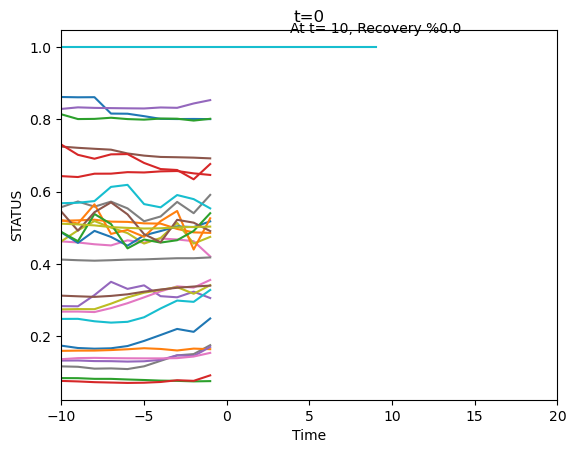

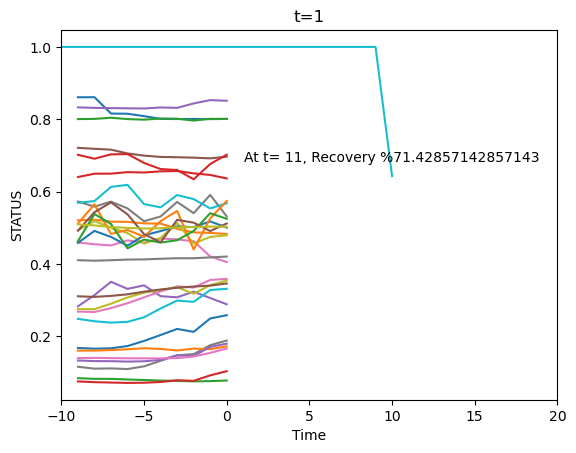

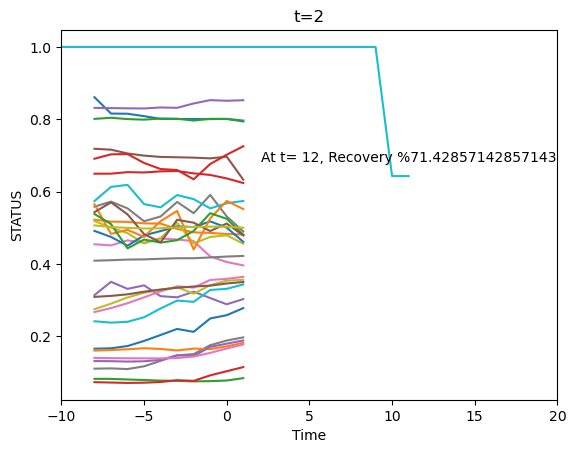

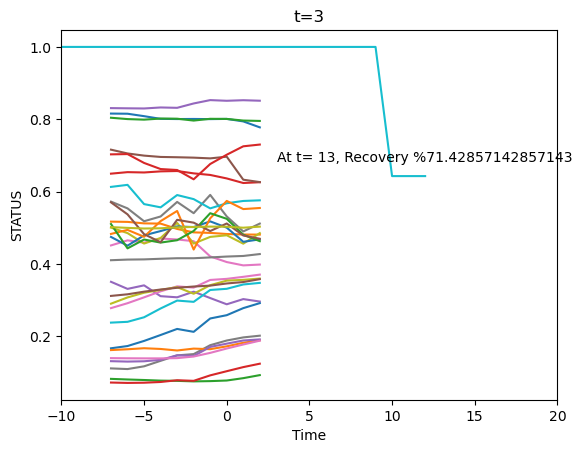

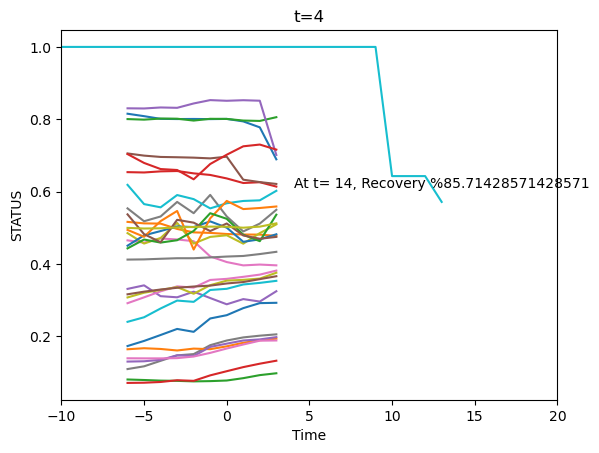

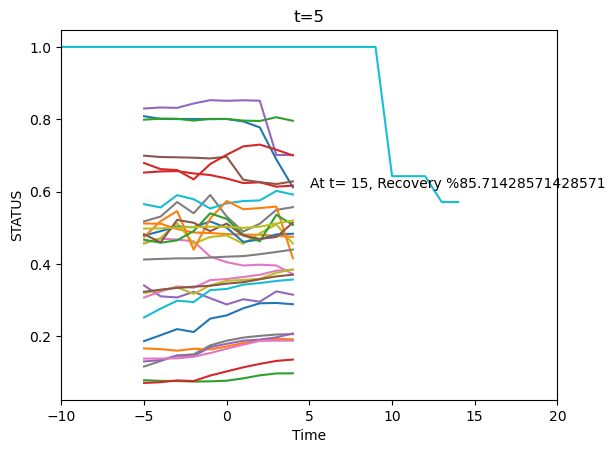

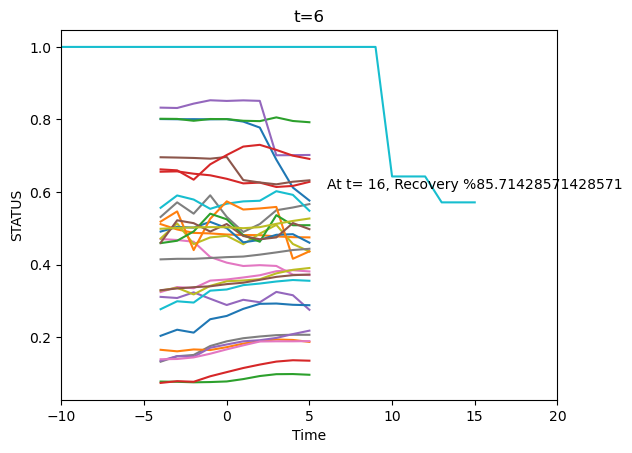

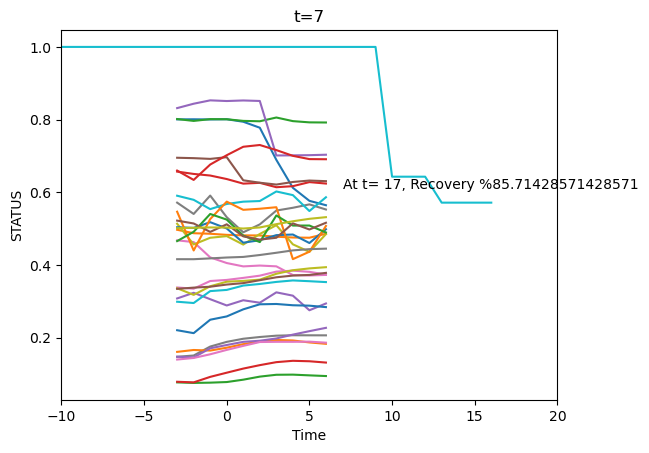

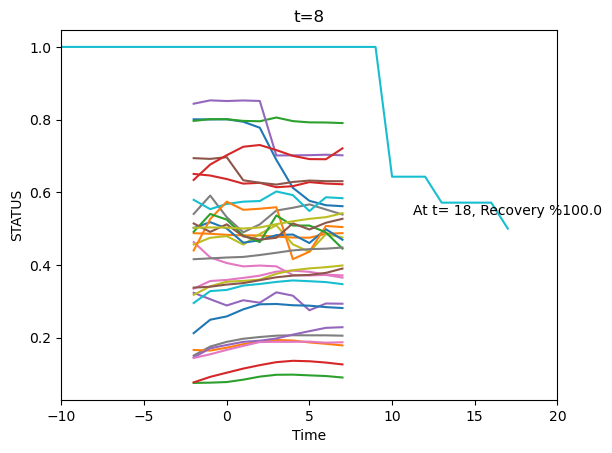

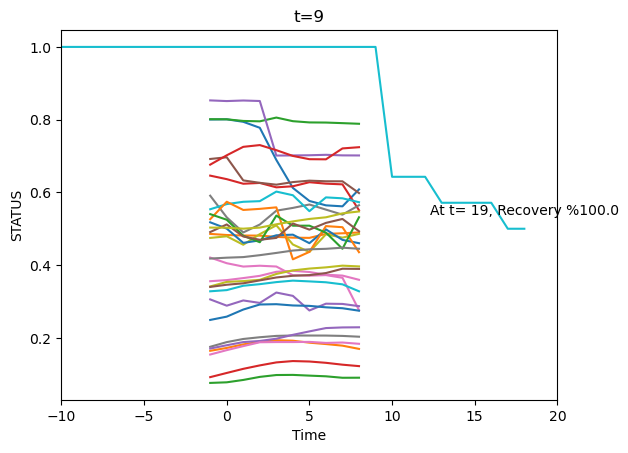

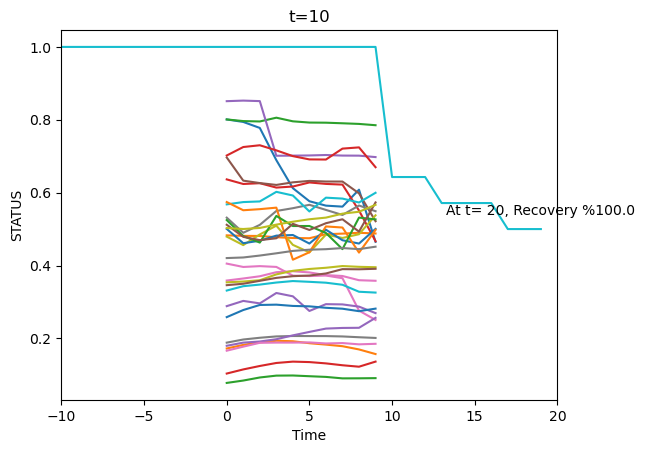

In [35]:
for j in range(lag+1):
    plt.figure()
    for i in range(mean_overall_sensor_behaviors.shape[1]):
        plt.plot(range(-window_size +j, j),mean_overall_scaled_sensor_behaviors[j:window_size+j,i])
    plt.plot(range(-window_size, total_shift - window_size +j),overall_machine_behavior.mean(axis=0)[:total_shift+j])

    label= f"At t= {j+window_size}, Recovery %{percentage_machine_recovery[total_shift+j-1]}"
    plt.annotate(label, # this is the text
                 (j+window_size-1,overall_machine_behavior.mean(axis=0)[total_shift+j-1]),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
    plt.xlim(-lag, window_size+lag)
    plt.ylabel('STATUS')
    plt.xlabel('Time')
    plt.title(f't={j}')
    plt.show()